In [3]:
import numpy as np
import cupy as cp
import matplotlib.pylab as plt

import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from ipywidgets import FloatProgress
from IPython.display import display, clear_output
import matplotlib.pylab as plt

/home/yoshihisa_furusawa/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
with open("../work/visualizing_with_deep_learning-master/imagenet1000_classification_list.txt", "r") as f:
    data = f.readlines()
#data[508]
#data[543]
#data[968]
data[227]
#data[99]
#data[951]

" 227: 'kelpie',\n"

In [14]:
index_dic = {}
class_list = [508,543,968,945,99,951,534,207,227]
for index, class_num in zip(np.arange(len(class_list)), class_list):
    index_dic[index] = class_num

In [15]:
print(index_dic)

{0: 508, 1: 543, 2: 968, 3: 945, 4: 99, 5: 951, 6: 534, 7: 207, 8: 227}


In [170]:
def normalize(x):
    return (x - x.min())/(x.max() - x.min())

class Model(chainer.Chain):
    def __init__(self, target_class,  xp=cp, model_name="resnet", image_init="zero", input_shape=(224,224,3)):
        super(Model, self).__init__()
        with self.init_scope():
            if image_init == "zero":
                img = np.zeros(input_shape).astype(np.float32)
            elif image_init == "random":
                img = np.random.uniform(low=0, high=255, size=input_shape).astype(np.float32)
            else:
                quit()
            
            if model_name == "resnet":
                img = L.model.vision.resnet.prepare(img)
            elif model_name == "vgg":
                img = L.model.vision.vgg.prepare(img)
            else:
                quit()
            
            self.image = chainer.Parameter(img[None])
            
        if model_name == "resnet":
                self.model = L.ResNet50Layers()
        elif model_name == "vgg":
            self.model = L.VGG16Layers()
        else:
            quit()

        self.model.to_gpu()
        self.model_name = model_name
        
    def __call__(self, target_unit_number, target_layer=None, rho=50, norm_axis=2):
        
        if target_layer is None:
            if self.model_name == "resnet":
                target_layer = 'fc6'
            elif self.model_name == "vgg":
                target_layer = 'fc8'

        input_image = F.normalize(self.image, axis=norm_axis)*rho
        with chainer.using_config('train', False):
            pred = self.model(input_image, layers=[target_layer])[target_layer]
            if pred.ndim == 4:
                pred_after_softmax = None
                activate_value = F.mean(pred[:, target_unit_number], axis=(1,2))
            else:
                pred_after_softmax = F.softmax(pred)[:, target_unit_number]
                activate_value = pred[:, target_unit_number]
            
            if (activate_value.array < 1e-26) &(pred.ndim == 4):
                pred_rank = np.argsort(chainer.cuda.to_cpu(F.mean(pred, axis=(2,3)).array), axis=1)[:, ::-1]
                print(pred_rank[0, :5])
        return activate_value, pred_after_softmax

target_class = index_dic[1]
model = Model(target_class=target_class, model_name="vgg")
model.to_gpu()

#optimizer = chainer.optimizers.SGD(lr=2000)
optimizer = chainer.optimizers.Adam(alpha=30)
optimizer.setup(model)
chainer.optimizer_hooks.WeightDecay(10)

print(data[target_class])

 543: 'dumbbell',



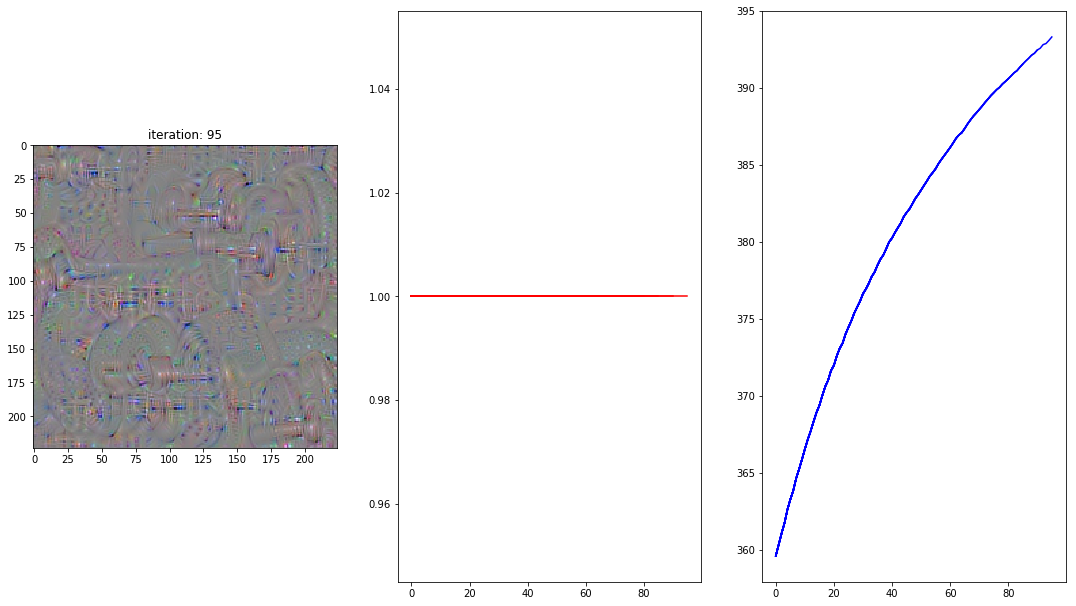

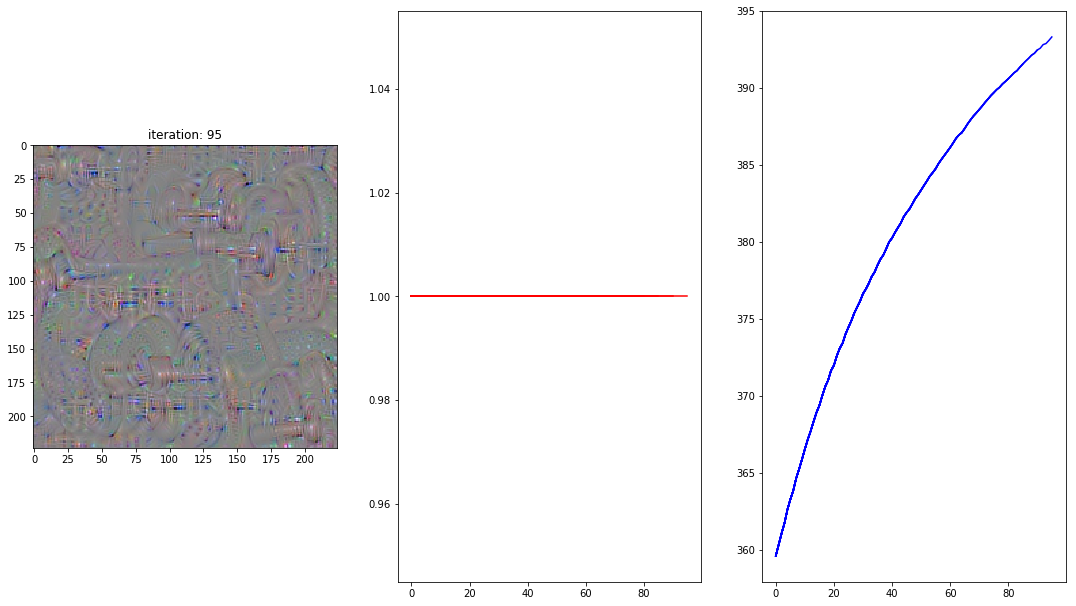

In [172]:
upper_thresh = 0
activete_list = []
pred_list = []
fig = plt.figure()
iterater_number = 100

for i in range(iterater_number):
    activate_value, pred_after_softmax = model(target_unit_number=target_class,
                                               rho=250,
                                               norm_axis=2,
                                               target_layer="fc8")
    model.cleargrads()
    (activate_value*(-1)).backward(retain_grad=True)
    optimizer.update()
    
    if pred_after_softmax is not None:
        pred_list.append(chainer.cuda.to_cpu(pred_after_softmax.array))
    activete_list.append(chainer.cuda.to_cpu(activate_value.array))
    
    if model.image.grad.sum() == 0.:
        break
    
    if i % 5 == 0:
        clear_output(wait = True)
        fig.set_size_inches(18.5, 10.5)
        plt.subplot(1,3,1)
        plt.title("iteration: " + str(i))
        #plt.imshow(normalize(chainer.cuda.to_cpu(F.normalize(model.image, axis=1)[0].transpose(1,2,0).array)))
        plt.imshow(normalize(chainer.cuda.to_cpu(model.image[0].transpose(1,2,0).array)))

        plt.subplot(1,3,2)
        plt.plot(np.arange(len(pred_list)), pred_list, c="r")

        plt.subplot(1,3,3)
        plt.plot(np.arange(len(activete_list)), activete_list, c="b")
        display(fig)
